# 1.IMPORT LIBRARIES

In [1]:
import pandas as pd
from warnings import filterwarnings
import glob
from analysis.analyzer import TTTH_Analyzer 
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import utils

In [2]:
filterwarnings('ignore')

# 2.READ AND OVERVIEW DATA

**CHÚ THÍCH:**
+ Đọc 3 file `ucla-2016, dfc1-2015, mskcc-2014`
+ Gộp 3 file tạo 1 dataset

In [3]:
list_data_path=glob.glob('melanoma/RFC7/*')
list_data_path

['melanoma/RFC7\\mel_ucla_2016_clinical_data.tsv',
 'melanoma/RFC7\\skcm_dfci_2015_clinical_data.tsv',
 'melanoma/RFC7\\skcm_mskcc_2014_clinical_data.tsv']

In [4]:
list_dataframe=[]
for path in list_data_path:
    # TÊN TỆP
    name_file=path.split('\\')[-1]
    print(f'{name_file.upper()} IS BEING PROCCESSED')
    # ĐỌC DATAFRAME
    df=pd.read_csv(path,delimiter='\t')
    # LỰA CHỌN FEATURE
    df=df[['Age at Diagnosis','Fraction Genome Altered','Mutation Count','Sex','Treatment','TMB (nonsynonymous)','Oncotree Code','Treatment Response']]
    # LOẠI BỎ NULL VALUES
    df=df.dropna()
    list_dataframe.append(df)
print('COMPLETE!')

MEL_UCLA_2016_CLINICAL_DATA.TSV IS BEING PROCCESSED
SKCM_DFCI_2015_CLINICAL_DATA.TSV IS BEING PROCCESSED
SKCM_MSKCC_2014_CLINICAL_DATA.TSV IS BEING PROCCESSED
COMPLETE!


In [5]:
df_data=pd.concat(list_dataframe)
df_data.reset_index(inplace=True,drop=True)

In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age at Diagnosis         202 non-null    int64  
 1   Fraction Genome Altered  202 non-null    float64
 2   Mutation Count           202 non-null    float64
 3   Sex                      202 non-null    object 
 4   Treatment                202 non-null    object 
 5   TMB (nonsynonymous)      202 non-null    float64
 6   Oncotree Code            202 non-null    object 
 7   Treatment Response       202 non-null    object 
dtypes: float64(3), int64(1), object(4)
memory usage: 12.8+ KB


# 3.PREPROCESS DATA

**CHÚ THÍCH:** 3 file đều có cách ghi treatment response khác nhau. Vì vậy thống nhất 1 cách ghi: `None-responders/Responders`

In [7]:
# Kiểm tra các giá trị treatment response
df_data['Treatment Response'].value_counts()

Treatment Response
1:Recurred/Progressed    99
nonresponse              41
Responder                20
Non-responder            17
response                 14
0:DiseaseFree            11
Name: count, dtype: int64

In [8]:
def treatment_response_category(x):
    if x in ['nonresponse','Non-responder','1:Recurred/Progressed']:
        return 'None-resopnders'
    return 'Responders'

In [9]:
# Map các giá trị
df_data['Treatment Response']=df_data['Treatment Response'].map(treatment_response_category)

**CHÚ THÍCH:** 3 file đều có cách ghi treatment khác nhau

In [10]:
# Kiểm tra các giá trị trong Treatment
df_data['Treatment'].value_counts()

Treatment
ipilimumab                 110
Ipilimumab                  49
Pembrolizumab               35
Tremelimumab                 3
Nivolumab                    2
Ipilimumab++vemurafenib      2
Ipilimumab+dacarbazine       1
Name: count, dtype: int64

In [11]:
# Map các giá trị
df_data['Treatment']=df_data['Treatment'].str.replace(pat='ipilimumab',repl='Ipilimumab',regex=False)

# 4.EDA

**CHÚ THÍCH:** Khai thác dữ liệu từ bộ dataset
+ Phân tích các biến thuộc categorical variables
+ Phân tích các biến thuộc numerical variables

In [12]:
list_categorical_var=df_data.select_dtypes(include='O').columns
list_numerical_var=df_data.select_dtypes(exclude='O').columns

In [13]:
_analyzer=TTTH_Analyzer()

## 4.1.CATEGORICAL DATA

Class count of Sex:

Sex
Male      139
Female     63
Name: count, dtype: int64


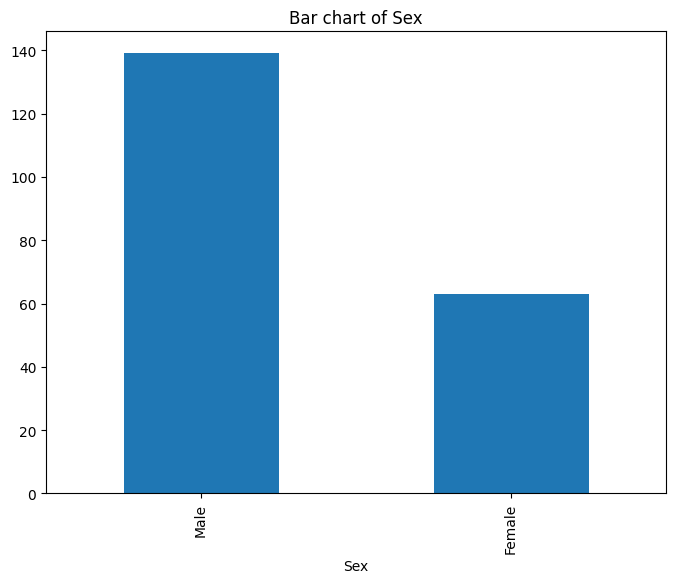

Class count of Treatment:

Treatment
Ipilimumab                 159
Pembrolizumab               35
Tremelimumab                 3
Nivolumab                    2
Ipilimumab++vemurafenib      2
Ipilimumab+dacarbazine       1
Name: count, dtype: int64


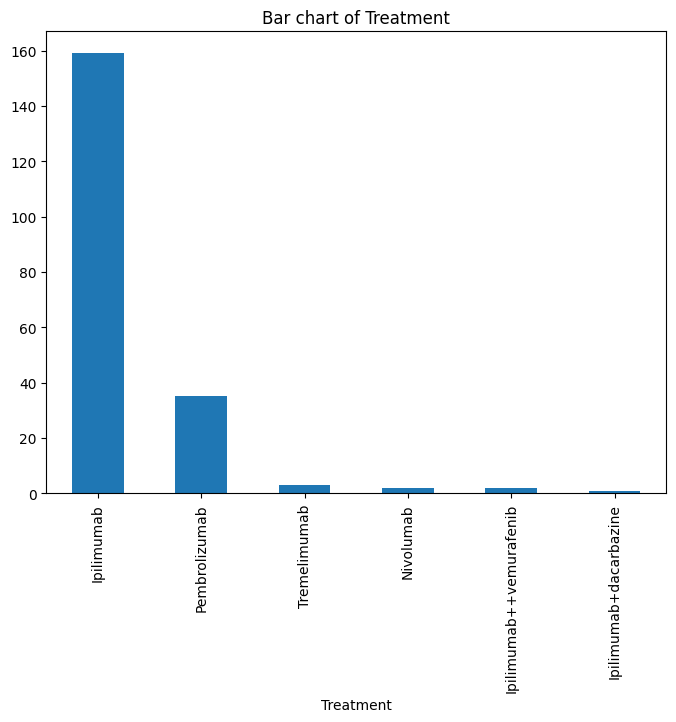

Class count of Oncotree Code:

Oncotree Code
SKCM    147
MEL      45
MUP       5
ACRM      5
Name: count, dtype: int64


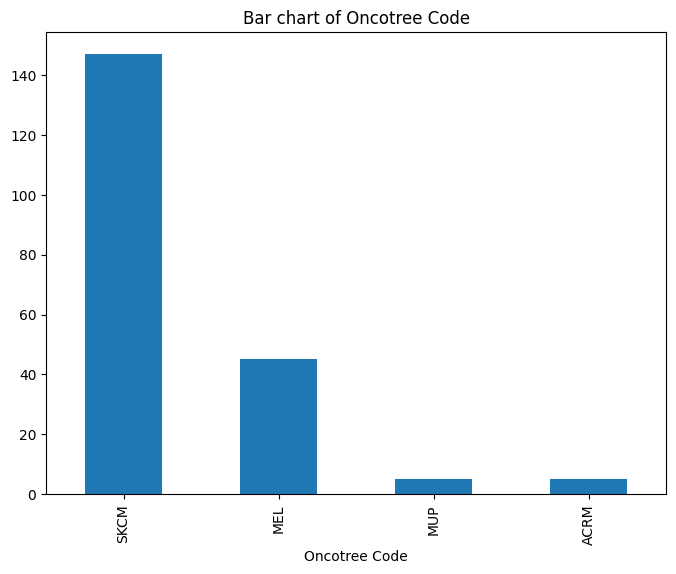

Class count of Treatment Response:

Treatment Response
None-resopnders    157
Responders          45
Name: count, dtype: int64


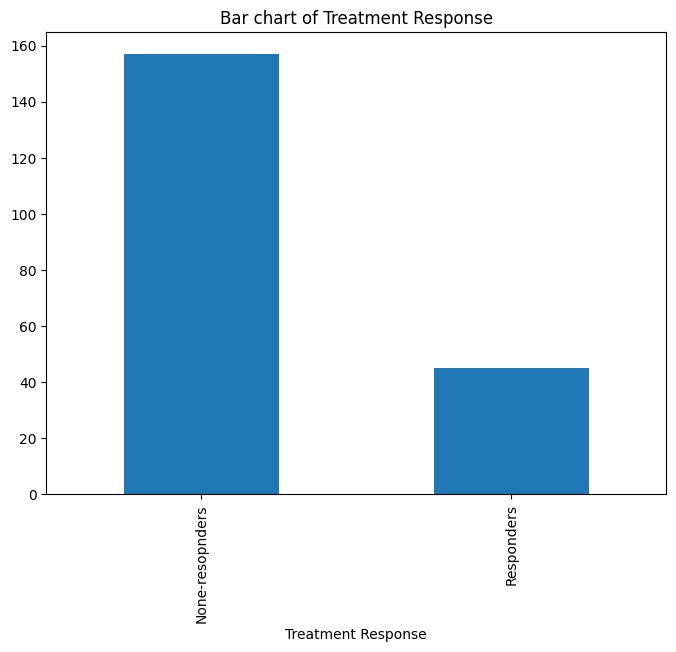

In [14]:
for var in list_categorical_var:
    _analyzer.analyze_category_variable(variable_name=var,df=df_data)

## 4.2.NUMERICAL DATA

=====
central tendency of Age at Diagnosis: {'mean': 59.118811881188115, 'median': 61.5, 'mode': 55, 'min': 18, 'max': 86, 'range': 68}
=====
Dispersion of Age at Diagnosis: 
 {'range': 68, 'q1': 49.0, 'q3': 70.0, 'iqr': 21.0, 'var': 233.36889808383816, 'skew': -0.5770545623838361, 'kurtosis': -0.2520805316506096}
=====


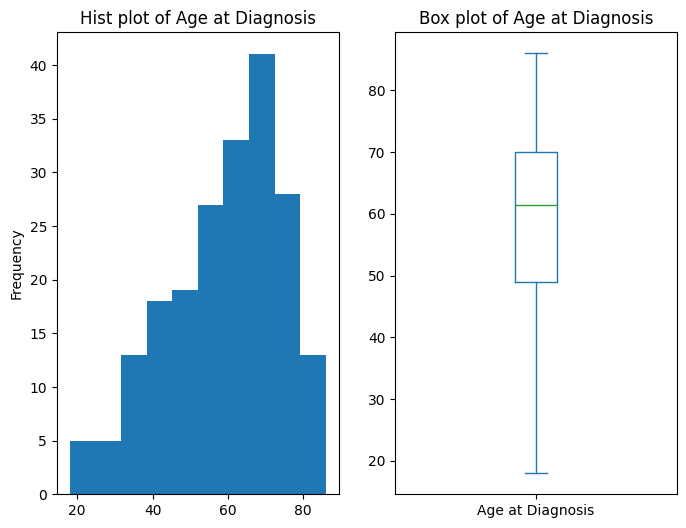

=====
central tendency of Fraction Genome Altered: {'mean': 0.35781435643564363, 'median': 0.3443, 'mode': 0.0, 'min': 0.0, 'max': 0.862, 'range': 0.862}
=====
Dispersion of Fraction Genome Altered: 
 {'range': 0.862, 'q1': 0.21175, 'q3': 0.528475, 'iqr': 0.31672500000000003, 'var': 0.0473910537729668, 'skew': 0.1929045639256084, 'kurtosis': -0.7046974583103056}
=====


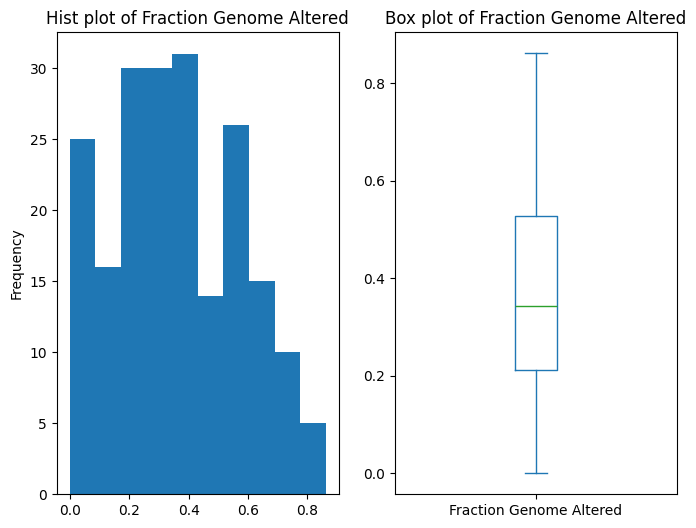

=====
central tendency of Mutation Count: {'mean': 539.1138613861386, 'median': 282.0, 'mode': 33.0, 'min': 1.0, 'max': 6167.0, 'range': 6166.0}
=====
Dispersion of Mutation Count: 
 {'range': 6166.0, 'q1': 109.25, 'q3': 610.75, 'iqr': 501.5, 'var': 613290.7581153641, 'skew': 3.832255646037986, 'kurtosis': 19.85991578294071}
=====


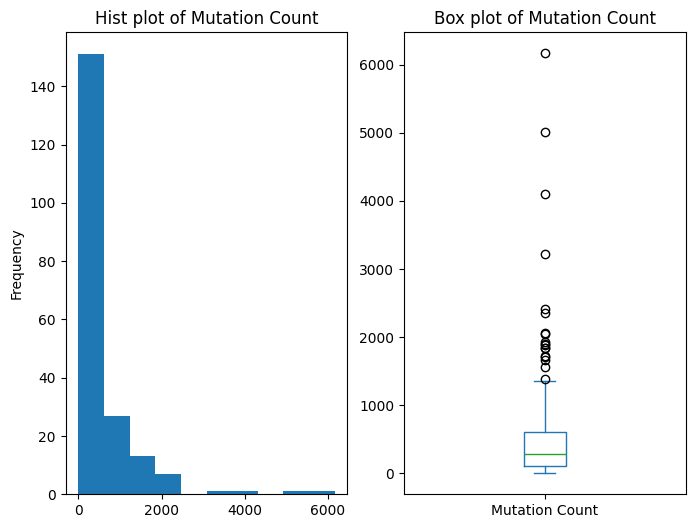

=====
central tendency of TMB (nonsynonymous): {'mean': 18.230198019796916, 'median': 9.633333333334999, 'mode': 1.1, 'min': 0.0333333333333, 'max': 205.933333333, 'range': 205.8999999996667}
=====
Dispersion of TMB (nonsynonymous): 
 {'range': 205.8999999996667, 'q1': 3.66666666667, 'q3': 20.491666666649998, 'iqr': 16.824999999979998, 'var': 695.7280774609749, 'skew': 3.771674189112754, 'kurtosis': 19.185305550764276}
=====


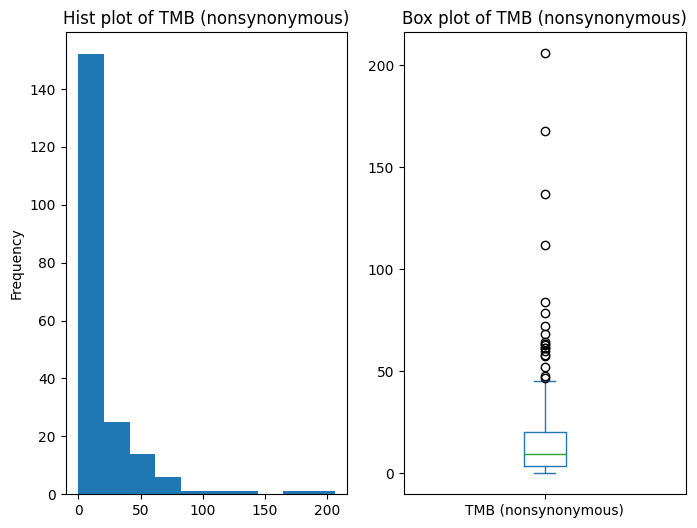

In [15]:
for var in list_numerical_var:
    _analyzer.analyze_numeric_variable(variable_name=var,df=df_data)

# 5.FEATURE ENGINE

## 5.1.ENCODING

**CHÚ THÍCH:** CHUẨN HÓA DỮ LIỆU CHO CATEGORICAL VARIABLES 
+ CÁC BIẾN KHÔNG PHỤ THUỘC `'Sex'`: SỬ DỤNG LABEL ENCODING
+ CÁC BIẾN KHÔNG PHỤ THUỘC `'Treatment','Oncotree Code'`: SỬ DỤNG ONE HOT ENCODING 
+ BIẾN PHỤ THUỘC `'Treatment Response'`: SỬ DỤNG LABEL ENCODING

In [12]:
encoder=OneHotEncoder()
onehot_encoded_data=encoder.fit_transform(df_data[['Sex','Treatment','Oncotree Code']])
onehot_encoded_data

,Sex_Female,Sex_Male,Treatment_Pembrolizumab,Treatment_Nivolumab,Treatment_Ipilimumab,Treatment_Tremelimumab,Treatment_Ipilimumab++vemurafenib,Treatment_Ipilimumab+dacarbazine,Oncotree Code_MEL,Oncotree Code_SKCM,Oncotree Code_MUP,Oncotree Code_ACRM
0,1,0,1,0,0,0,0,0,1,0,0,0
1,0,1,1,0,0,0,0,0,1,0,0,0
2,0,1,1,0,0,0,0,0,1,0,0,0
3,0,1,1,0,0,0,0,0,1,0,0,0
4,1,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
197,1,0,0,0,0,0,1,0,0,0,0,1
198,0,1,0,0,1,0,0,0,0,1,0,0
199,1,0,0,0,1,0,0,0,0,0,0,1
200,0,1,0,0,1,0,0,0,0,1,0,0


In [13]:
label_encoded_data=(df_data['Treatment Response']=='Responders').astype('int')
label_encoded_data

0      0
1      0
2      0
3      0
4      1
      ..
197    0
198    0
199    1
200    1
201    0
Name: Treatment Response, Length: 202, dtype: int32

## 5.2.SCALING

**CHÚ THÍCH:** CHUẨN HÓA DỮ LIỆU CHO NUMERICAL VARIABLES 
+ CÁC BIẾN KHÔNG PHỤ THUỘC `'TMB (nonsynonymous)','Mutation Count'`: SỬ DỤNG LOG SCALING
+  CÁC BIẾN KHÔNG PHỤ THUỘC `'Age at Diagnosis'`: SỬ DỤNG MIN MAX SCALING

In [14]:
log_scaled_data=df_data[['TMB (nonsynonymous)','Mutation Count']].apply(lambda x: np.log1p(x))
log_scaled_data

,TMB (nonsynonymous),Mutation Count
0,4.158883,7.545918
1,2.226424,5.517453
2,2.268684,5.568345
3,1.704748,4.919981
4,2.864104,6.210600
...,...,...
197,0.902868,3.583519
198,2.244250,5.517453
199,1.213923,4.276666
200,1.835245,5.023881


In [15]:
minmaxscaler=MinMaxScaler()
min_max_scaled_data=minmaxscaler.fit_transform(df_data[['Age at Diagnosis']])
min_max_scaled_df=pd.DataFrame(min_max_scaled_data,columns=minmaxscaler.get_feature_names_out())
min_max_scaled_df

,Age at Diagnosis
0,0.705882
1,0.617647
2,0.279412
3,0.602941
4,0.514706
...,...
197,0.632353
198,0.544118
199,0.544118
200,0.500000


## 5.3.DATA PREPARATION FOR MODEL TRAINING

In [16]:
# Y
y=label_encoded_data
# X
X=pd.concat([min_max_scaled_df,log_scaled_data,df_data[['Fraction Genome Altered']],onehot_encoded_data],axis=1)
X

,Age at Diagnosis,TMB (nonsynonymous),Mutation Count,Fraction Genome Altered,Sex_Female,Sex_Male,Treatment_Pembrolizumab,Treatment_Nivolumab,Treatment_Ipilimumab,Treatment_Tremelimumab,Treatment_Ipilimumab++vemurafenib,Treatment_Ipilimumab+dacarbazine,Oncotree Code_MEL,Oncotree Code_SKCM,Oncotree Code_MUP,Oncotree Code_ACRM
0,0.705882,4.158883,7.545918,0.5546,1,0,1,0,0,0,0,0,1,0,0,0
1,0.617647,2.226424,5.517453,0.5397,0,1,1,0,0,0,0,0,1,0,0,0
2,0.279412,2.268684,5.568345,0.6750,0,1,1,0,0,0,0,0,1,0,0,0
3,0.602941,1.704748,4.919981,0.6357,0,1,1,0,0,0,0,0,1,0,0,0
4,0.514706,2.864104,6.210600,0.3010,1,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,0.632353,0.902868,3.583519,0.4052,1,0,0,0,0,0,1,0,0,0,0,1
198,0.544118,2.244250,5.517453,0.5582,0,1,0,0,1,0,0,0,0,1,0,0
199,0.544118,1.213923,4.276666,0.3502,1,0,0,0,1,0,0,0,0,0,0,1
200,0.500000,1.835245,5.023881,0.3126,0,1,0,0,1,0,0,0,0,1,0,0


# 6.TRAIN MODEL

## 6.1.CHUẨN BỊ DỮ LIỆU

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,stratify=y,train_size=0.8)

## 6.2.TRAIN MÔ HÌNH

In [18]:
# Cross validation mô hình RFC7
result_cross_validation=utils.cross_validation_by_RFC(10,X_train,y_train,'accuracy',seed=42)
result_cross_validation

array([0.82352941, 0.6875    , 0.8125    , 0.8125    , 0.75      ,
       0.625     , 0.875     , 0.625     , 0.75      , 0.8125    ])

In [24]:
# TRAIN MÔ HÌNH RFC7
df_result,df_features=utils.training_RFC(X_train,y_train,X_test,y_test,100)

In [25]:
df_result

,accuracy_test,accuracy_train,recall,precison,f1
0,0.804878,1.0,0.222222,0.666667,0.333333
1,0.780488,1.0,0.111111,0.500000,0.181818
2,0.804878,1.0,0.222222,0.666667,0.333333
3,0.780488,1.0,0.222222,0.500000,0.307692
4,0.780488,1.0,0.222222,0.500000,0.307692
...,...,...,...,...,...
95,0.780488,1.0,0.222222,0.500000,0.307692
96,0.804878,1.0,0.222222,0.666667,0.333333
97,0.756098,1.0,0.111111,0.333333,0.166667
98,0.756098,1.0,0.111111,0.333333,0.166667


In [26]:
df_features

,Age at Diagnosis,TMB (nonsynonymous),Mutation Count,Fraction Genome Altered,Sex_Female,Sex_Male,Treatment_Pembrolizumab,Treatment_Nivolumab,Treatment_Ipilimumab,Treatment_Tremelimumab,Treatment_Ipilimumab++vemurafenib,Treatment_Ipilimumab+dacarbazine,Oncotree Code_MEL,Oncotree Code_SKCM,Oncotree Code_MUP,Oncotree Code_ACRM
0,0.189488,0.220902,0.191737,0.209263,0.023328,0.018570,0.048164,0.003777,0.044702,0.0,0.000232,0.000104,0.027085,0.018998,0.003303,0.000346
1,0.206820,0.200002,0.207954,0.203147,0.020524,0.015434,0.049133,0.007784,0.053364,0.0,0.000223,0.000575,0.013830,0.017311,0.003670,0.000229
2,0.193360,0.211084,0.204058,0.188124,0.024065,0.020705,0.060509,0.006326,0.045269,0.0,0.000369,0.001121,0.022415,0.015989,0.006358,0.000246
3,0.181912,0.219829,0.197324,0.203103,0.022521,0.024859,0.058017,0.003298,0.043339,0.0,0.000327,0.000036,0.021819,0.017393,0.005917,0.000305
4,0.183027,0.215466,0.196380,0.215769,0.018322,0.020970,0.060149,0.005159,0.036592,0.0,0.000316,0.000133,0.028037,0.014669,0.004750,0.000261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.182619,0.214010,0.211155,0.202953,0.020324,0.020797,0.063219,0.008117,0.034749,0.0,0.000817,0.000084,0.020734,0.014393,0.005697,0.000332
96,0.201839,0.198474,0.203104,0.209875,0.018662,0.018658,0.055940,0.005153,0.045541,0.0,0.000583,0.000210,0.019881,0.017294,0.004175,0.000611
97,0.193257,0.200803,0.199526,0.199355,0.022207,0.022450,0.049914,0.005472,0.051216,0.0,0.000443,0.000219,0.032390,0.016686,0.005738,0.000324
98,0.202645,0.211573,0.193182,0.191505,0.018282,0.019038,0.071219,0.004353,0.036515,0.0,0.000559,0.000489,0.026835,0.018018,0.005463,0.000325


## 6.3.KẾT QUẢ VÀ TRỰC QUAN HÓA

In [28]:
print(f'KẾT QUẢ CROSSVALIDATION: {result_cross_validation.mean():.4f}±{result_cross_validation.std():.4f}')

KẾT QUẢ CROSSVALIDATION: 0.7574±0.0821


In [29]:
df_result_final=utils.caculate_result(df_result)
df_result_final

,mean,std
recall,0.156667,0.054923
f1,0.233354,0.071554
precison,0.484000,0.123590
accuracy_test,0.777561,0.016726
accuracy_train,0.999938,0.000621


In [30]:
df_features_final=utils.caculate_result(df_features)
df_features_final

,mean,std
Treatment_Tremelimumab,0.000000,0.000000
Oncotree Code_ACRM,0.000409,0.000236
Treatment_Ipilimumab+dacarbazine,0.000416,0.000292
Treatment_Ipilimumab++vemurafenib,0.000494,0.000263
Oncotree Code_MUP,0.005260,0.001195
Treatment_Nivolumab,0.005287,0.001281
Oncotree Code_SKCM,0.017925,0.002847
Sex_Female,0.019917,0.002323
Sex_Male,0.019958,0.002166
Oncotree Code_MEL,0.023639,0.004998


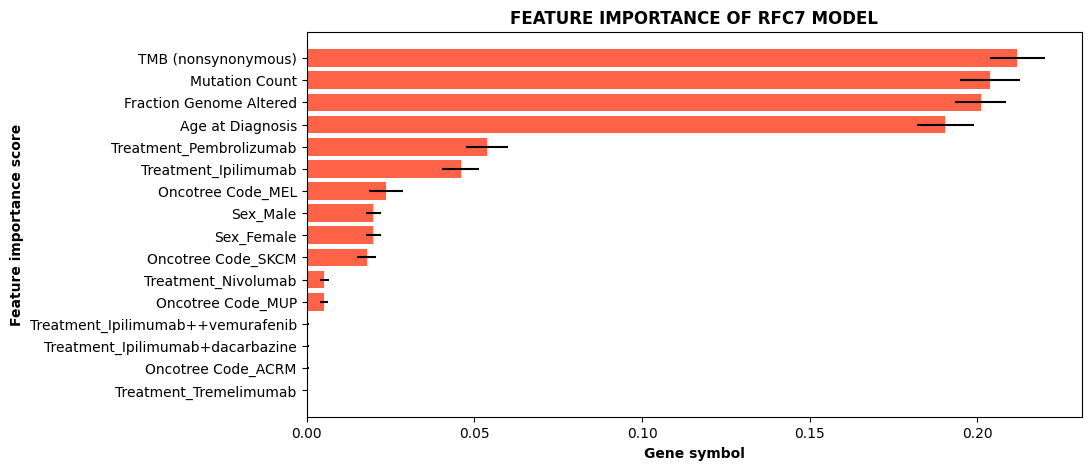

In [31]:
utils.feature_importance_graph(df_features_final,'FEATURE IMPORTANCE OF RFC7 MODEL')